In [50]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 26.0MB/s ta 0:00:01
sparkmagic 0.12.5 has requirement ipykernel<5,>=4.2.2, but you'll have ipykernel 5.1.3 which is incompatible.
sparkmagic 0.12.5 has requirement ipython<7,>=4.0.2, but you'll have ipython 7.9.0 which is incompatible.
sparkmagic 0.12.5 has requirement notebook<6.0,>=4.2, but you'll have notebook 6.0.2 which is incompatible.
jupyter-console 5.2.0 has requirement prompt_toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 2.0.10 which is incompatible.
ipython-gremlin 1.0.0 has requirement ipython==5.3.0, but you'll have ipython 7.9.0 which is incompatible.
gremlinpython 3.4.4 has requirement tornado<5.0,>=4.4.1, but you'll have tornado 6.0.3 which is incompatible.
docker-compose 1.24.1 has requirement jsonschema<3,>=2.5.1, but you'll have jsonschema 3.2.0 which is incompatible.
botocore 1.13.19 has requirement python-dateutil<2.8.1,>=2.1; python_version >= "2.7", but you'll have python-dateutil 2.8.1 which is incompatib

In [58]:
%matplotlib inline

from collections import defaultdict
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import boto3
import wordcloud as wc
import csv

In [74]:
bucket='large-text-understanding-angelaw'
prefix='translated/politics-2000/'

In [75]:
!aws s3 sync s3://angelaw-chinese-news-analysis/Translated/select/politics/ s3://$bucket/$prefix/ --quiet

In [3]:
## do it in the console

In [5]:
import boto3

comprehend_client = boto3.client('comprehend')

In [41]:
topic_modeling_job_id = 'fbd96d42fd7d4e2e1092fbdc0549a5c3' 


In [42]:
topics_detection_response = comprehend_client.describe_topics_detection_job(
    JobId=topic_modeling_job_id
)
output_file = topics_detection_response['TopicsDetectionJobProperties']['OutputDataConfig']['S3Uri']
num_topics = topics_detection_response['TopicsDetectionJobProperties']['NumberOfTopics']

In [43]:
num_topics

30

In [44]:
OUTPUT_FOLDER='output'

def make_tmp_folder(folder_name):
    try:
        os.makedirs(folder_name)
    except OSError as e:
        print("{} folder already exists".format(folder_name))

make_tmp_folder(OUTPUT_FOLDER)

output folder already exists


In [45]:
download_output=os.path.join(OUTPUT_FOLDER, f'output-{num_topics}-topics.tar.gz')
!aws s3 cp $output_file $download_output

download: s3://angelaw-chinese-news-analysis/output/THUCNews/en/politics-2000/735324722473-TOPICS-fbd96d42fd7d4e2e1092fbdc0549a5c3/output/output.tar.gz to output/output-30-topics.tar.gz


In [46]:
!tar -xvzf $download_output -C $OUTPUT_FOLDER/

doc-topics.csv
topic-terms.csv


In [56]:
topic_terms_csv = os.path.join(OUTPUT_FOLDER, 'topic-terms.csv')
doc_topics_csv = os.path.join(OUTPUT_FOLDER, 'doc-topics.csv')

In [54]:
def parse_topic_terms(topic_terms_csv):
    topics=defaultdict(dict)
    with open(topic_terms_csv) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
                topic = row[0]
                term = row[1]
                freq= float(row[2])
                topics[topic][term]=freq
                line_count += 1
        print(f'Processed {line_count} lines.')
    return topics

def plot_topic_word_cloud(topics):      
    plt.figure(figsize=(20,16))
    n_col = 4
    for i, item in enumerate(topics):

        title_str = 'Topic{}'.format(item)

        wordcloud = wc.WordCloud(background_color='white').fit_words(topics[item])

        plt.subplot(len(topics) // n_col+1, n_col, i+1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title_str)
                      

Column names are topic, term, weight
Processed 301 lines.


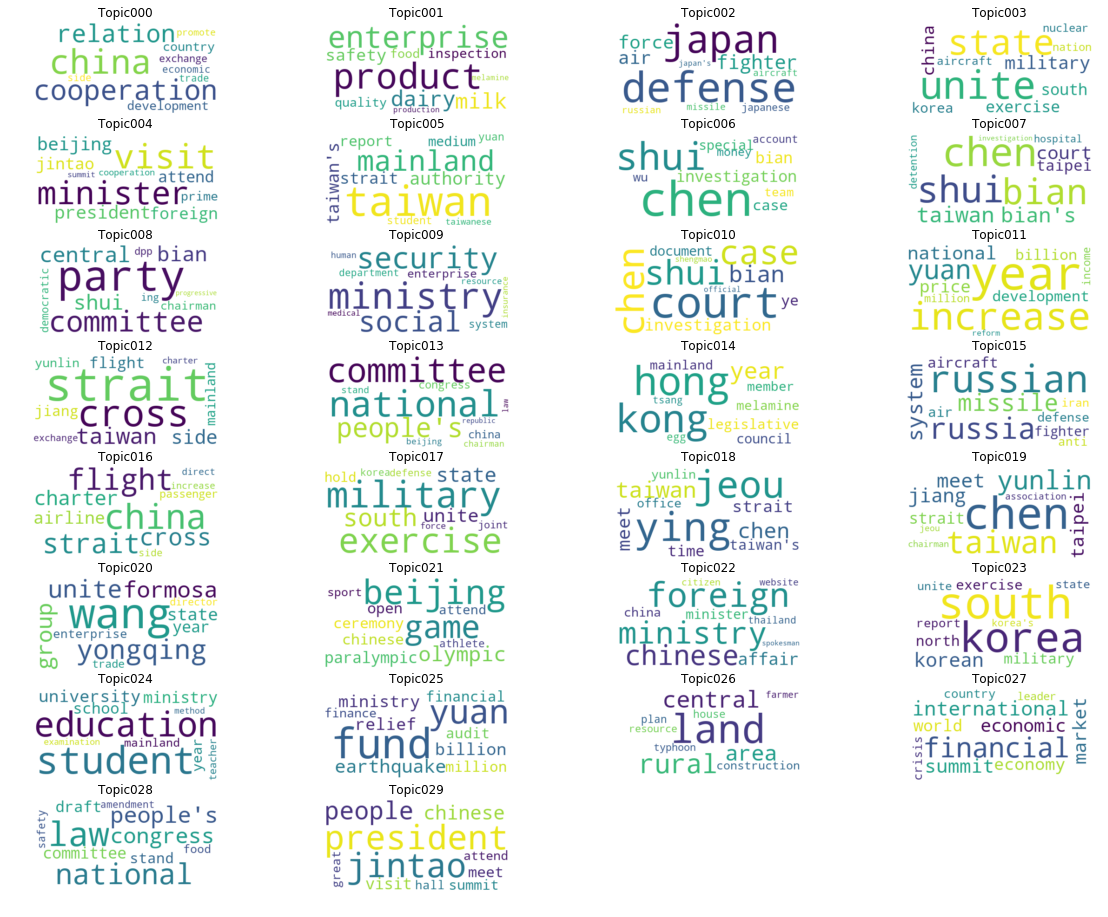

In [55]:
topics = parse_topic_terms(topic_terms_csv)
plot_topic_word_cloud(topics)

In [63]:
def parse_doc_topic_distribution(doc_topics_csv):
    doc_topic_df = pd.read_csv(doc_topics_csv)
    return doc_topic_df

def summarize_topic_distributions(doc_topic_df):
    df_summary = doc_topic_df.groupby(['topic']).sum()
    df_summary['proportion'] = df_summary['proportion']/(df_summary['proportion'].sum())
    df_summary = df_summary.sort_values(by=['proportion'], ascending=False)
    return df_summary


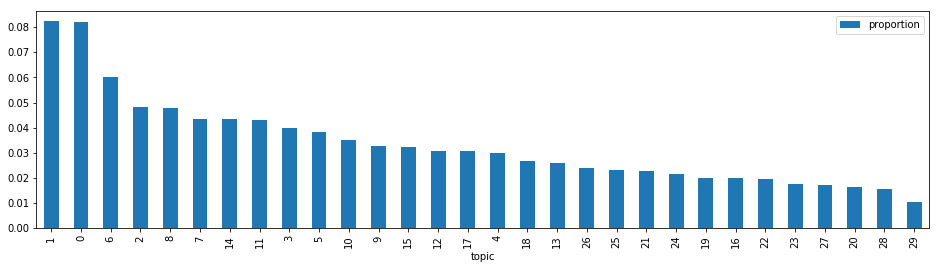

In [64]:
doc_topic_df = parse_doc_topic_distribution(doc_topics_csv)
df_summary = summarize_topic_distributions(doc_topic_df)
df_summary.plot(kind='bar', figsize=(16,4))

In [65]:
doc_topic_df.head()

,docname,topic,proportion
0,340067.txt,26,0.329804
1,340067.txt,5,0.326640
2,340067.txt,16,0.191902
3,340067.txt,4,0.151654
4,340934.txt,0,0.681685


In [66]:
topic_of_interest=1

In [76]:
def find_top_document_for_topic(topic_of_interest, max_results=10):
    filtered_by_topic_df = doc_topic_df[doc_topic_df['topic']==topic_of_interest]
    filtered_by_topic_df = filtered_by_topic_df.sort_values(by=['proportion'], ascending=False)
    return filtered_by_topic_df.head(max_results)

In [77]:
top_10_docs = find_top_document_for_topic(topic_of_interest, max_results=10)
top_10_docs

,docname,topic,proportion
4493,340808.txt,1,1.000000
5225,340599.txt,1,1.000000
6415,340665.txt,1,1.000000
7500,341213.txt,1,1.000000
293,340852.txt,1,1.000000
4153,341597.txt,1,1.000000
4179,340865.txt,1,0.988370
3351,340767.txt,1,0.985053
6765,340971.txt,1,0.981313
11,341038.txt,1,0.981131


In [78]:
doc_id = top_10_docs.iloc[0,0]
doc_id

'340808.txt'

In [79]:
!aws s3 cp s3://$bucket/$prefix/$doc_id $OUTPUT_FOLDER/

download: s3://large-text-understanding-angelaw/translated/politics-2000//340808.txt to output/340808.txt


In [80]:
!cat $OUTPUT_FOLDER/$doc_id

Quality Inspection Administration: 47 brands of liquid milk did not detect melamine
 Xinhua net Beijing on September 26 (reporter Xu Bo, Zhu Shaobin) reporter 26 learned from the QSIQ, QSIQ recently and some major city supply yogurt, pasteurized milk, sterilization milk and other main varieties of liquid milk melamine sampling testing, have not detected melamine.
 QSIQ this time a total of 47 brands of 296 batches of products, mainly including Yili, Mengniu, bright, three yuan, Wandashan, Wei Gang market share of well-known brand liquid milk products, have not detected melamine.
 It is understood that the liquid milk products tested at this time also include the probiotic kefir (xylitol) of Tianjin Huaming Dairy Co., Ltd., kefir milk from Beijing Jianxun Food Co., Ltd., Chenguang Pure milk pasteurized milk from Shenzhen Chenguang Dairy Co., Ltd. Snow Bioengineering (Shenzhen) Co., Ltd. seasoned kefir milk, Changsha Wangwang Food Co., Ltd. Milk, yogurt yogurt yogurt (strawberry flavor) 

## Load results into Neptune